In [4]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.6 MB/s eta 0:00:00


In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [26]:
# Load and preprocess the data
def load_and_preprocess(file_path):
    """
    Load and preprocess the retail data
    - Convert dates
    - Calculate transaction values
    - Remove returns and missing values
    """
    # Read the CSV file
    df = pd.read_csv(file_path, encoding='latin-1')

    # Convert InvoiceDate to datetime
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

    # Calculate total amount for each transaction
    df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

    # Remove cancelled orders and returns (negative quantities)
    df = df[df['Quantity'] > 0]

    # Remove missing CustomerIDs
    df = df.dropna(subset=['CustomerID'])

    # Convert CustomerID to integer
    df['CustomerID'] = df['CustomerID'].astype(int)

    return df

# Calculate RFM metrics
def calculate_rfm(df):
    """
    Calculate Recency, Frequency, Monetary metrics for each customer
    - Recency: days since last purchase
    - Frequency: number of purchases
    - Monetary: total spending
    """
    # Calculate maximum date for recency
    max_date = df['InvoiceDate'].max() + timedelta(days=1)

    # Calculate RFM metrics for each customer
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
        'InvoiceNo': lambda x: len(x.unique()),  # Frequency
        'TotalAmount': 'sum'  # Monetary
    })

    # Rename columns
    rfm.columns = ['Recency', 'Frequency', 'Monetary']

    # Filter out any potential outliers
    rfm = rfm[rfm['Monetary'] > 0]

    return rfm

# Calculate additional metrics
def calculate_additional_metrics(df, rfm_df):
    """
    Calculate additional customer behavior metrics:
    - Average order value
    - Purchase regularity
    - Product diversity
    - Average items per transaction
    """
    # Average order value
    customer_orders = df.groupby(['CustomerID', 'InvoiceNo']).agg({
        'TotalAmount': 'sum'
    }).reset_index()

    avg_order = customer_orders.groupby('CustomerID').agg({
        'TotalAmount': 'mean'
    })
    avg_order.columns = ['AvgOrderValue']

    # Product diversity (number of unique products purchased)
    product_diversity = df.groupby('CustomerID').agg({
        'StockCode': lambda x: len(x.unique())
    })
    product_diversity.columns = ['ProductDiversity']

    # Average items per transaction
    items_per_order = df.groupby(['CustomerID', 'InvoiceNo']).agg({
        'Quantity': 'sum'
    }).reset_index()

    avg_items = items_per_order.groupby('CustomerID').agg({
        'Quantity': 'mean'
    })
    avg_items.columns = ['AvgItemsPerOrder']

    # Purchase regularity (standard deviation of days between purchases)
    purchase_dates = df.groupby(['CustomerID', 'InvoiceNo']).agg({
        'InvoiceDate': 'first'
    }).reset_index()

    # Function to calculate purchase regularity
    def calculate_regularity(customer_dates):
        if len(customer_dates) <= 1:
            return np.nan
        sorted_dates = sorted(customer_dates)
        days_between = [(sorted_dates[i] - sorted_dates[i-1]).days
                        for i in range(1, len(sorted_dates))]
        return np.std(days_between) if days_between else np.nan

    purchase_regularity = purchase_dates.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: calculate_regularity(x)
    })
    purchase_regularity.columns = ['PurchaseRegularity']

    # Merge all metrics
    additional_metrics = pd.concat([
        avg_order,
        product_diversity,
        avg_items,
        purchase_regularity
    ], axis=1)

    # Fill NaN values in regularity for customers with only one purchase
    additional_metrics['PurchaseRegularity'].fillna(0, inplace=True)

    # Merge with RFM
    enhanced_rfm = rfm_df.join(additional_metrics)

    return enhanced_rfm

# Enhanced segmentation using K-means
def enhanced_segmentation(enhanced_rfm):
    """
    Perform customer segmentation using K-means clustering:
    - Scale features
    - Find optimal number of clusters
    - Apply K-means
    - Add segment labels
    """
    # Select features for clustering
    features = [
        'Recency', 'Frequency', 'Monetary',
        'AvgOrderValue', 'ProductDiversity',
        'AvgItemsPerOrder', 'PurchaseRegularity'
    ]

    # Handle any remaining NaN values
    features_df = enhanced_rfm[features].fillna(0)

    # Log transform monetary features to reduce skewness
    for col in ['Monetary', 'AvgOrderValue']:
        features_df[col] = np.log1p(features_df[col])

    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)

    # Find optimal number of clusters using silhouette score
    silhouette_scores = []
    inertia_values = []
    K = range(2, 11)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(scaled_features)

        # Calculate silhouette score
        score = silhouette_score(scaled_features, kmeans.labels_)
        silhouette_scores.append(score)

        # Calculate inertia (within-cluster sum of squares)
        inertia_values.append(kmeans.inertia_)

    # Plot elbow curve for visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K, silhouette_scores, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')

    plt.subplot(1, 2, 2)
    plt.plot(K, inertia_values, 'ro-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.tight_layout()

    # Get optimal number of clusters
    optimal_k = K[np.argmax(silhouette_scores)]

    # Perform final clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    enhanced_rfm['Cluster'] = kmeans.fit_predict(scaled_features)

    # Add meaningful segment labels
    segment_descriptions = enhanced_rfm.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'AvgOrderValue': 'mean',
        'ProductDiversity': 'mean',
        'AvgItemsPerOrder': 'mean'
    })

    # Create segment labels based on metrics
    segment_labels = {}
    for cluster in segment_descriptions.index:
        desc = segment_descriptions.loc[cluster]

        # Determine loyalty status (based on frequency)
        if desc['Frequency'] > segment_descriptions['Frequency'].quantile(0.75):
            loyalty = "Loyal"
        elif desc['Frequency'] > segment_descriptions['Frequency'].median():
            loyalty = "Regular"
        else:
            loyalty = "Occasional"

        # Determine value (based on monetary)
        if desc['Monetary'] > segment_descriptions['Monetary'].quantile(0.75):
            value = "High-Value"
        elif desc['Monetary'] > segment_descriptions['Monetary'].median():
            value = "Mid-Value"
        else:
            value = "Low-Value"

        # Determine recency
        if desc['Recency'] < segment_descriptions['Recency'].quantile(0.25):
            recency = "Active"
        elif desc['Recency'] < segment_descriptions['Recency'].median():
            recency = "Recent"
        else:
            recency = "Inactive"

        segment_labels[cluster] = f"{recency} {loyalty} {value}"

    # Add segment labels to the dataframe
    enhanced_rfm['Segment'] = enhanced_rfm['Cluster'].map(segment_labels)

    return enhanced_rfm, segment_descriptions

# Updated visualization function
def visualize_segments(segmented_df):
    """
    Create visualizations to understand customer segments
    - PCA for dimension reduction
    - Segment distribution
    - Radar charts for segment profiles
    """
    # Apply PCA for visualization
    features = [
        'Recency', 'Frequency', 'Monetary',
        'AvgOrderValue', 'ProductDiversity',
        'AvgItemsPerOrder'
    ]

    # Prepare data
    features_df = segmented_df[features].copy()
    for col in ['Monetary', 'AvgOrderValue']:
        features_df[col] = np.log1p(features_df[col])

    # Scale data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features_df)

    # Apply PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_data)

    # Create dataframe with PCA results
    pca_df = pd.DataFrame(
        data=principal_components,
        columns=['PC1', 'PC2']
    )
    pca_df['Cluster'] = segmented_df['Cluster'].values

    # Plot PCA with clusters
    plt.figure(figsize=(12, 8))

    # Ensure numeric cluster is used for coloring
    cluster_values = pca_df['Cluster'].astype(int)

    # Create a custom color palette based on the number of clusters
    n_clusters = len(cluster_values.unique())
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

    # Manual scatter plot to avoid warnings
    for i, cluster in enumerate(sorted(cluster_values.unique())):
        cluster_data = pca_df[cluster_values == cluster]
        plt.scatter(
            cluster_data['PC1'],
            cluster_data['PC2'],
            c=[colors[i]],
            label=f'Cluster {cluster}',
            alpha=0.7,
            s=50
        )

    plt.title('Customer Segments Visualization (PCA)', fontsize=15)
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Create segment distribution chart with numeric clusters first
    plt.figure(figsize=(14, 7))

    # Segment distribution by segment name
    ax1 = plt.subplot(1, 2, 1)
    cluster_counts = segmented_df['Cluster'].value_counts().sort_index()
    cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_counts)))

    bars = ax1.bar(
        [f'Cluster {c}' for c in cluster_counts.index],
        cluster_counts.values,
        color=cluster_colors
    )

    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width()/2.,
            height + 50,
            f'{int(height)}',
            ha='center'
        )

    plt.title('Distribution by Cluster', fontsize=14)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45)

    # Segment distribution by segment name
    ax2 = plt.subplot(1, 2, 2)
    segment_counts = segmented_df['Segment'].value_counts()
    segment_colors = plt.cm.plasma(np.linspace(0, 1, len(segment_counts)))

    bars = ax2.bar(
        segment_counts.index,
        segment_counts.values,
        color=segment_colors
    )

    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width()/2.,
            height + 50,
            f'{int(height)}',
            ha='center'
        )

    plt.title('Distribution by Segment', fontsize=14)
    plt.xlabel('Segment')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    # Create a feature importance visualization
    plt.figure(figsize=(14, 6))

    # Get the PCA components
    components = pca.components_
    feature_names = features

    # Create a heatmap of feature importance in principal components
    plt.subplot(1, 2, 1)
    sns.heatmap(
        components,
        annot=True,
        cmap='coolwarm',
        yticklabels=['PC1', 'PC2'],
        xticklabels=feature_names
    )
    plt.title('Feature Importance in Principal Components')

    # Create cluster profile comparison
    plt.subplot(1, 2, 2)

    # Prepare data for segment profiles
    profile_data = segmented_df.groupby('Cluster')[features].mean()

    # Scale the profile data for comparison
    min_max_scaler = lambda x: (x - x.min()) / (x.max() - x.min())
    profile_scaled = profile_data.apply(min_max_scaler)

    # Plot heatmap of segment profiles
    sns.heatmap(
        profile_scaled.T,
        annot=True,
        fmt='.2f',
        cmap='YlGnBu',
        linewidths=0.5
    )
    plt.title('Relative Strength of Features by Cluster')
    plt.ylabel('Features')
    plt.xlabel('Cluster')

    plt.tight_layout()

    return pca_df


# Function to create an advanced visualization dashboard
def create_segment_dashboard(segmented_df, segment_insights):
    """
    Create a comprehensive dashboard of customer segments
    with multiple visualizations for business insights
    """
    # Set the style
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']

    # Create subplot grid
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 3)

    # 1. Monetary value by segment
    ax1 = fig.add_subplot(gs[0, 0])
    segment_order = segment_insights.sort_values('Monetary', ascending=False).index
    sns.barplot(
        x=segment_insights.loc[segment_order, 'Monetary'],
        y=segment_order,
        palette='YlOrRd',
        ax=ax1
    )
    ax1.set_title('Average Monetary Value by Segment', fontsize=14)
    ax1.set_xlabel('Average Spending ($)')
    ax1.set_ylabel('')

    # Add value labels
    for i, v in enumerate(segment_insights.loc[segment_order, 'Monetary']):
        ax1.text(v + 100, i, f'${v:,.0f}', va='center')

    # 2. Frequency by segment
    ax2 = fig.add_subplot(gs[0, 1])
    segment_order = segment_insights.sort_values('Frequency', ascending=False).index
    sns.barplot(
        x=segment_insights.loc[segment_order, 'Frequency'],
        y=segment_order,
        palette='YlGnBu',
        ax=ax2
    )
    ax2.set_title('Average Purchase Frequency by Segment', fontsize=14)
    ax2.set_xlabel('Number of Purchases')
    ax2.set_ylabel('')

    # Add value labels
    for i, v in enumerate(segment_insights.loc[segment_order, 'Frequency']):
        ax2.text(v + 0.2, i, f'{v:.1f}', va='center')

    # 3. Customer distribution pie chart
    ax3 = fig.add_subplot(gs[0, 2])
    segment_insights['CustomerCount'].plot(
        kind='pie',
        autopct='%1.1f%%',
        colors=plt.cm.tab10.colors,
        ax=ax3
    )
    ax3.set_title('Customer Distribution by Segment', fontsize=14)
    ax3.set_ylabel('')

    # 4. Predicted quarterly value by segment
    ax4 = fig.add_subplot(gs[1, 0])
    segment_order = segment_insights.sort_values('PredictedQuarterlyValue', ascending=False).index
    sns.barplot(
        x=segment_insights.loc[segment_order, 'PredictedQuarterlyValue'],
        y=segment_order,
        palette='Greens',
        ax=ax4
    )
    ax4.set_title('Predicted Quarterly Value by Segment', fontsize=14)
    ax4.set_xlabel('Predicted Value ($)')
    ax4.set_ylabel('')

    # Add value labels
    for i, v in enumerate(segment_insights.loc[segment_order, 'PredictedQuarterlyValue']):
        ax4.text(v + 100, i, f'${v:,.0f}', va='center')

    # 5. Growth potential score by segment
    ax5 = fig.add_subplot(gs[1, 1])
    segment_order = segment_insights.sort_values('GrowthPotentialScore', ascending=False).index
    bars = sns.barplot(
        x=segment_insights.loc[segment_order, 'GrowthPotentialScore'],
        y=segment_order,
        palette='Reds',
        ax=ax5
    )
    ax5.set_title('Growth Potential Score by Segment', fontsize=14)
    ax5.set_xlabel('Growth Potential (0-100)')
    ax5.set_ylabel('')
    ax5.set_xlim(0, 100)

    # Add value labels
    for i, v in enumerate(segment_insights.loc[segment_order, 'GrowthPotentialScore']):
        ax5.text(v + 2, i, f'{v:.1f}', va='center')

    # 6. Recency vs Frequency scatter plot with monetary as size
    ax6 = fig.add_subplot(gs[1, 2])

    # Create a copy with segment as category
    plot_df = segmented_df.copy()
    plot_df['SegmentCategory'] = pd.Categorical(plot_df['Segment'])

    # Create a sample if dataset is large
    if len(plot_df) > 1000:
        plot_sample = plot_df.sample(1000, random_state=42)
    else:
        plot_sample = plot_df

    scatter = ax6.scatter(
        x='Recency',
        y='Frequency',
        s=plot_sample['Monetary'] / 100,  # Scale size for visibility
        c=plot_sample['Cluster'].astype('category').cat.codes,
        cmap='viridis',
        alpha=0.6,
        data=plot_sample
    )

    # Add legend for size
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6,
                                            num=4, func=lambda x: x * 100)
    size_legend = ax6.legend(handles, labels, loc="upper right", title="Monetary Value")

    ax6.set_title('Recency vs Frequency (size = Monetary)', fontsize=14)
    ax6.set_xlabel('Recency (days)')
    ax6.set_ylabel('Purchase Frequency')
    ax6.set_xscale('log')
    ax6.set_yscale('log')
    ax6.grid(True, alpha=0.3)

    # 7. Average order value by segment
    ax7 = fig.add_subplot(gs[2, 0])
    segment_order = segment_insights.sort_values('AvgOrderValue', ascending=False).index
    sns.barplot(
        x=segment_insights.loc[segment_order, 'AvgOrderValue'],
        y=segment_order,
        palette='PuRd',
        ax=ax7
    )
    ax7.set_title('Average Order Value by Segment', fontsize=14)
    ax7.set_xlabel('Average Order Value ($)')
    ax7.set_ylabel('')

    # Add value labels
    for i, v in enumerate(segment_insights.loc[segment_order, 'AvgOrderValue']):
        ax7.text(v + 100, i, f'${v:,.0f}', va='center')

    # 8. Product diversity by segment
    ax8 = fig.add_subplot(gs[2, 1])
    segment_order = segment_insights.sort_values('ProductDiversity', ascending=False).index
    sns.barplot(
        x=segment_insights.loc[segment_order, 'ProductDiversity'],
        y=segment_order,
        palette='BuPu',
        ax=ax8
    )
    ax8.set_title('Product Diversity by Segment', fontsize=14)
    ax8.set_xlabel('Unique Products Purchased')
    ax8.set_ylabel('')

    # Add value labels
    for i, v in enumerate(segment_insights.loc[segment_order, 'ProductDiversity']):
        ax8.text(v + 2, i, f'{v:.0f}', va='center')

    # 9. Key summary metrics table
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.axis('off')

    # Calculate key metrics
    total_customers = segment_insights['CustomerCount'].sum()
    total_revenue = (segment_insights['Monetary'] * segment_insights['CustomerCount']).sum()
    avg_customer_value = total_revenue / total_customers
    predicted_quarterly_revenue = (segment_insights['PredictedQuarterlyValue'] *
                                segment_insights['CustomerCount']).sum()

    # Create text summary
    summary_text = [
        f"Total Customers: {total_customers:,.0f}",
        f"Total Revenue: ${total_revenue:,.0f}",
        f"Average Customer Value: ${avg_customer_value:,.0f}",
        f"Predicted Quarterly Revenue: ${predicted_quarterly_revenue:,.0f}",
        f"\nSegment Breakdown:",
    ]

    for segment, row in segment_insights.iterrows():
        summary_text.append(
            f"\n{segment}:"
            f"\n  • {row['CustomerCount']:,.0f} customers ({row['PercentOfCustomers']:.1f}%)"
            f"\n  • ${row['Monetary']:,.0f} avg. spend"
            f"\n  • {row['Frequency']:.1f} avg. purchases"
            f"\n  • Growth potential: {row['GrowthPotentialScore']:.1f}/100"
        )

    ax9.text(0, 1, '\n'.join(summary_text), va='top', fontsize=12)

    # Adjust layout and add title
    plt.suptitle('Customer Segmentation Analysis Dashboard', fontsize=20, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    return fig

# Calculate customer value prediction
def predict_future_value(segmented_df, df):
    """
    Predict future customer value based on historical behavior
    - Calculate projected value for next quarter
    - Add growth potential estimates
    """
    # Add days since first purchase
    customer_first_purchase = df.groupby('CustomerID')['InvoiceDate'].min()
    max_date = df['InvoiceDate'].max()

    customer_age = pd.DataFrame({
        'CustomerID': customer_first_purchase.index,
        'FirstPurchase': customer_first_purchase.values,
        'DaysSinceFirst': [(max_date - date).days for date in customer_first_purchase.values]
    })

    # Calculate purchase rate (purchases per month)
    segmented_df = segmented_df.join(customer_age.set_index('CustomerID'))
    segmented_df['MonthsActive'] = segmented_df['DaysSinceFirst'] / 30.44  # Average days in a month
    segmented_df['PurchaseRate'] = segmented_df['Frequency'] / np.maximum(segmented_df['MonthsActive'], 1)

    # Predict next quarter value (simple prediction based on historical rate)
    segmented_df['QuarterlyRate'] = segmented_df['PurchaseRate'] * 3  # 3 months
    segmented_df['AvgTransactionValue'] = segmented_df['Monetary'] / segmented_df['Frequency']
    segmented_df['PredictedQuarterlyValue'] = segmented_df['QuarterlyRate'] * segmented_df['AvgTransactionValue']

    # Calculate growth potential
    # Recent customers with high frequency get higher potential
    segmented_df['GrowthPotential'] = (
        (1 / np.log1p(segmented_df['Recency'])) *
        np.log1p(segmented_df['Frequency']) *
        np.log1p(segmented_df['Monetary'])
    )

    # Normalize growth potential to 0-100 scale
    min_potential = segmented_df['GrowthPotential'].min()
    max_potential = segmented_df['GrowthPotential'].max()
    segmented_df['GrowthPotentialScore'] = (
        (segmented_df['GrowthPotential'] - min_potential) /
        (max_potential - min_potential) * 100
    )

    return segmented_df


In [27]:
# Function to generate segment interpretations and recommendations
def interpret_segments(segment_insights):
    """
    Generate detailed interpretations and business recommendations
    for each customer segment
    """
    interpretations = {}
    recommendations = {}

    for segment, metrics in segment_insights.iterrows():
        # Generate interpretation based on segment metrics
        interpretation = f"### {segment} Segment Analysis\n\n"

        # Basic metrics overview
        interpretation += f"**Customer Base:** {metrics['CustomerCount']:,.0f} customers "
        interpretation += f"({metrics['PercentOfCustomers']:.1f}% of total)\n\n"

        interpretation += f"**Key Metrics:**\n"
        interpretation += f"- **Recency:** {metrics['Recency']:.1f} days since last purchase\n"
        interpretation += f"- **Frequency:** {metrics['Frequency']:.1f} purchases on average\n"
        interpretation += f"- **Monetary:** ${metrics['Monetary']:,.2f} average total spend\n"
        interpretation += f"- **Average Order Value:** ${metrics['AvgOrderValue']:,.2f}\n"
        interpretation += f"- **Product Diversity:** {metrics['ProductDiversity']:.1f} unique products purchased\n"
        interpretation += f"- **Predicted Quarterly Value:** ${metrics['PredictedQuarterlyValue']:,.2f}\n"
        interpretation += f"- **Growth Potential Score:** {metrics['GrowthPotentialScore']:.1f}/100\n\n"

        # Detailed segment interpretation
        if "Active Loyal" in segment:
            interpretation += "**Segment Characteristics:**\n"
            interpretation += "This segment represents your loyal customer base with recent purchases. "
            interpretation += "These customers shop frequently and demonstrate strong engagement with your products. "

            if "High-Value" in segment:
                interpretation += "They are high spenders who contribute significantly to your revenue. "
                interpretation += "Their high average order value indicates comfort with premium products.\n\n"
            elif "Mid-Value" in segment:
                interpretation += "They are consistent spenders with moderate basket sizes. "
                interpretation += "Their purchase frequency makes them valuable despite moderate order values.\n\n"
            else:  # Low-Value
                interpretation += "While loyal, these customers tend to make smaller purchases. "
                interpretation += "Their value comes from consistency rather than transaction size.\n\n"

        elif "Active Occasional" in segment:
            interpretation += "**Segment Characteristics:**\n"
            interpretation += "This segment consists of customers who have purchased recently but infrequently. "
            interpretation += "They are engaged but haven't developed a consistent purchase pattern. "

            if "High-Value" in segment:
                interpretation += "Despite their infrequent purchases, they spend significantly when they do buy. "
                interpretation += "These may be seasonal shoppers or customers who make occasional large purchases.\n\n"
            elif "Mid-Value" in segment:
                interpretation += "These customers make moderate purchases on an irregular basis. "
                interpretation += "They may be new customers still exploring your product range.\n\n"
            else:  # Low-Value
                interpretation += "These are likely new or casual customers who have made small, infrequent purchases. "
                interpretation += "They show interest but haven't committed to regular purchases.\n\n"

        elif "Recent" in segment:
            interpretation += "**Segment Characteristics:**\n"
            interpretation += "This segment includes customers with moderately recent purchases. "
            interpretation += "They haven't bought very recently but are still within a reasonable timeframe. "

            if "Loyal" in segment:
                interpretation += "These were previously consistent customers who may be showing early signs of churn. "
                interpretation += "Their historical loyalty makes them good candidates for re-engagement.\n\n"
            else:  # Occasional
                interpretation += "These customers make purchases sporadically and are at risk of becoming inactive. "
                interpretation += "Their irregular purchase pattern suggests low brand loyalty.\n\n"

        elif "Inactive" in segment:
            interpretation += "**Segment Characteristics:**\n"
            interpretation += "This segment represents customers who haven't purchased in a significant period. "

            if "Loyal" in segment:
                interpretation += "These were previously loyal customers who have stopped purchasing. "
                interpretation += "Their historical engagement suggests they may be receptive to win-back campaigns.\n\n"
            elif "Occasional" in segment and "High-Value" in segment:
                interpretation += "These customers made infrequent but large purchases and have since become inactive. "
                interpretation += "They may be project-based buyers or seasonal shoppers who make large but infrequent purchases.\n\n"
            else:  # Occasional Low/Mid-Value
                interpretation += "These customers made few, low-value purchases before becoming inactive. "
                interpretation += "They likely had limited engagement with your brand from the beginning.\n\n"

        interpretations[segment] = interpretation

        # Generate strategic recommendations
        recommendation = f"### Strategic Recommendations for {segment} Segment\n\n"

        if "Active Loyal" in segment:
            if "High-Value" in segment:
                recommendation += "**Priority: HIGH** - Retention and premium development\n\n"
                recommendation += "1. **Loyalty program tier upgrades** - Offer exclusive benefits and early access to new products\n"
                recommendation += "2. **Personal shopping assistance** - Provide dedicated customer service representatives\n"
                recommendation += "3. **Premium product recommendations** - Suggest complementary high-value items\n"
                recommendation += "4. **Customer advisory board** - Invite to provide feedback on future products\n"
                recommendation += "5. **Exclusive events** - Host VIP shopping experiences\n"
            elif "Mid-Value" in segment:
                recommendation += "**Priority: HIGH** - Value enhancement and loyalty rewards\n\n"
                recommendation += "1. **Tiered loyalty rewards** - Encourage incremental spending increases\n"
                recommendation += "2. **Bundle offers** - Create packages that increase average order value\n"
                recommendation += "3. **Category expansion** - Introduce them to new product categories\n"
                recommendation += "4. **Referral incentives** - Reward for bringing in new customers\n"
                recommendation += "5. **Subscription options** - Offer convenience and discounts for recurring purchases\n"
            else:  # Low-Value
                recommendation += "**Priority: MEDIUM** - Frequency maintenance and value growth\n\n"
                recommendation += "1. **Basket building incentives** - Offer tiered discounts based on order size\n"
                recommendation += "2. **Cross-sell campaigns** - Suggest complementary products at checkout\n"
                recommendation += "3. **Educational content** - Share product usage ideas to increase utility\n"
                recommendation += "4. **Limited-time promotions** - Create urgency for additional purchases\n"
                recommendation += "5. **Loyalty points acceleration** - Offer bonus points for larger orders\n"

        elif "Active Occasional" in segment:
            if "High-Value" in segment:
                recommendation += "**Priority: HIGH** - Frequency development with value preservation\n\n"
                recommendation += "1. **Personalized reorder reminders** - Gently prompt based on typical purchase cycle\n"
                recommendation += "2. **Curated collections** - Create personalized showcases of new items\n"
                recommendation += "3. **Incentivized frequency program** - Reward for increasing purchase regularity\n"
                recommendation += "4. **Premium product education** - Share detailed information about high-value items\n"
                recommendation += "5. **Seasonal preview access** - Offer early access to new collections\n"
            else:  # Mid/Low-Value
                recommendation += "**Priority: MEDIUM** - Engagement and frequency building\n\n"
                recommendation += "1. **Second purchase incentives** - Offer special discount on next order\n"
                recommendation += "2. **Product discovery campaigns** - Highlight diverse product categories\n"
                recommendation += "3. **Engagement-focused emails** - Share content that drives site visits\n"
                recommendation += "4. **Limited-time free shipping** - Reduce barriers to repeat purchase\n"
                recommendation += "5. **Social media engagement** - Invite to follow and engage with brand content\n"

        elif "Recent" in segment:
            recommendation += "**Priority: HIGH** - Re-engagement and churn prevention\n\n"
            recommendation += "1. **Win-back offers** - Provide compelling incentives to return\n"
            recommendation += "2. **Product updates** - Highlight new items since last purchase\n"
            recommendation += "3. **Feedback surveys** - Learn why purchase frequency has decreased\n"
            recommendation += "4. **Personalized recommendations** - Based on previous purchase history\n"
            recommendation += "5. **Re-engagement email sequence** - Series of targeted communications\n"

        elif "Inactive" in segment:
            if "High-Value" in segment:
                recommendation += "**Priority: MEDIUM** - High-value recovery\n\n"
                recommendation += "1. **VIP win-back program** - Exclusive offers for returning customers\n"
                recommendation += "2. **Personal outreach** - Direct contact from customer service\n"
                recommendation += "3. **Major product announcements** - Share significant new offerings\n"
                recommendation += "4. **Substantial incentives** - Provide meaningful discounts to return\n"
                recommendation += "5. **Account review** - Ensure no service issues caused departure\n"
            elif "Loyal" in segment:
                recommendation += "**Priority: MEDIUM** - Loyalty recovery\n\n"
                recommendation += "1. **'We miss you' campaigns** - Emotionally engaging re-engagement\n"
                recommendation += "2. **Loyalty status preservation** - Extend status with next purchase\n"
                recommendation += "3. **New product highlights** - Showcase innovation since last purchase\n"
                recommendation += "4. **Re-engagement survey** - Learn what would bring them back\n"
                recommendation += "5. **Win-back discount ladder** - Increasing incentives over time\n"
            else:  # Occasional Low/Mid-Value
                recommendation += "**Priority: LOW** - Selective reactivation\n\n"
                recommendation += "1. **Final reactivation attempt** - Last-chance special offer\n"
                recommendation += "2. **New customer-like offers** - Treat as essentially new to the brand\n"
                recommendation += "3. **Low-cost engagement** - Social media and email reconnection\n"
                recommendation += "4. **Feedback survey** - Learn about their departure for future improvement\n"
                recommendation += "5. **Automated reactivation program** - Periodic reminders with minimal resource investment\n"

        recommendations[segment] = recommendation

    return interpretations, recommendations


# Function to generate segment-based KPIs for monitoring
def generate_segment_kpis(segment_insights):
    """
    Generate key performance indicators (KPIs) to track for each segment
    """
    kpi_recommendations = {}

    for segment, metrics in segment_insights.iterrows():
        kpis = f"### Key Performance Indicators for {segment}\n\n"

        # Common KPIs for all segments
        kpis += "**Universal KPIs:**\n"
        kpis += "- Segment size (customer count and percentage)\n"
        kpis += "- Segment revenue contribution\n"
        kpis += "- Segment profitability\n\n"

        # Segment-specific KPIs
        kpis += "**Segment-Specific KPIs:**\n"

        if "Active Loyal" in segment:
            kpis += "- Retention rate\n"
            kpis += "- Repeat purchase rate\n"
            kpis += "- Average time between purchases\n"
            kpis += "- Loyalty program participation rate\n"
            kpis += "- Product category penetration\n"
            kpis += "- Share of wallet (estimated)\n"

            if "High-Value" in segment:
                kpis += "- Premium product adoption rate\n"
                kpis += "- VIP service utilization\n"
                kpis += "- Referral generation\n"
            else:
                kpis += "- Average order value growth\n"
                kpis += "- Cross-sell success rate\n"

        elif "Active Occasional" in segment:
            kpis += "- Conversion to loyal segment\n"
            kpis += "- Purchase frequency growth\n"
            kpis += "- Email engagement rate\n"
            kpis += "- Website visit frequency\n"
            kpis += "- Second purchase rate\n"

            if "High-Value" in segment:
                kpis += "- Repeat high-value purchase rate\n"
                kpis += "- Premium product exploration\n"
            else:
                kpis += "- Average order value growth\n"
                kpis += "- Product category exploration\n"

        elif "Recent" in segment:
            kpis += "- Reactivation rate\n"
            kpis += "- Days since last purchase\n"
            kpis += "- Win-back campaign response rate\n"
            kpis += "- Churn rate\n"
            kpis += "- Email open and click rates\n"

        elif "Inactive" in segment:
            kpis += "- Reactivation rate\n"
            kpis += "- Win-back campaign ROI\n"
            kpis += "- Email deliverability\n"
            kpis += "- Unsubscribe rate\n"

            if "High-Value" in segment or "Loyal" in segment:
                kpis += "- Recovery rate compared to acquisition cost\n"
                kpis += "- Feedback survey completion rate\n"

        kpi_recommendations[segment] = kpis

    return kpi_recommendations


# Function to export results for PowerBI integration
def export_for_powerbi(final_df, segment_insights, file_prefix='retail_analysis_'):
    """
    Export segmentation results in formats optimized for PowerBI
    """
    # Export main customer data with segments
    customer_export = final_df.reset_index()
    customer_export.to_csv(f'{file_prefix}customers.csv', index=False)

    # Export segment profiles
    segment_insights.to_csv(f'{file_prefix}segment_profiles.csv')

    # Create date dimension for time analysis
    dates_df = pd.DataFrame({
        'Date': pd.date_range(
            start=final_df['FirstPurchase'].min(),
            end=final_df['FirstPurchase'].max() + pd.Timedelta(days=90),
            freq='D'
        )
    })

    # Add date attributes
    dates_df['Year'] = dates_df['Date'].dt.year
    dates_df['Quarter'] = dates_df['Date'].dt.quarter
    dates_df['Month'] = dates_df['Date'].dt.month
    dates_df['MonthName'] = dates_df['Date'].dt.strftime('%B')
    dates_df['Week'] = dates_df['Date'].dt.isocalendar().week
    dates_df['Day'] = dates_df['Date'].dt.day
    dates_df['Weekday'] = dates_df['Date'].dt.weekday
    dates_df['WeekdayName'] = dates_df['Date'].dt.strftime('%A')
    dates_df['IsWeekend'] = dates_df['Weekday'].isin([5, 6]).astype(int)

    # Export date dimension
    dates_df.to_csv(f'{file_prefix}date_dimension.csv', index=False)

    # Create segment summary for easy PowerBI metrics
    segment_summary = pd.DataFrame({
        'Segment': segment_insights.index,
        'CustomerCount': segment_insights['CustomerCount'],
        'PercentOfTotal': segment_insights['PercentOfCustomers'],
        'TotalRevenue': segment_insights['Monetary'] * segment_insights['CustomerCount'],
        'AvgMonetary': segment_insights['Monetary'],
        'AvgFrequency': segment_insights['Frequency'],
        'AvgRecency': segment_insights['Recency'],
        'AvgOrderValue': segment_insights['AvgOrderValue'],
        'ProductDiversity': segment_insights['ProductDiversity'],
        'PredictedValue': segment_insights['PredictedQuarterlyValue'] * segment_insights['CustomerCount'],
        'GrowthScore': segment_insights['GrowthPotentialScore']
    })

    # Add segment priority based on value and growth potential
    segment_summary['Priority'] = 'Medium'

    # High priority: large customer base OR high monetary value OR high growth potential
    high_priority_mask = (
        (segment_summary['CustomerCount'] > segment_summary['CustomerCount'].median()) |
        (segment_summary['AvgMonetary'] > segment_summary['AvgMonetary'].median()) |
        (segment_summary['GrowthScore'] > 50)
    )
    segment_summary.loc[high_priority_mask, 'Priority'] = 'High'

    # Low priority: small customer base AND low monetary value AND low growth potential
    low_priority_mask = (
        (segment_summary['CustomerCount'] < segment_summary['CustomerCount'].median()/2) &
        (segment_summary['AvgMonetary'] < segment_summary['AvgMonetary'].median()/2) &
        (segment_summary['GrowthScore'] < 25)
    )
    segment_summary.loc[low_priority_mask, 'Priority'] = 'Low'

    # Export segment summary
    segment_summary.to_csv(f'{file_prefix}segment_summary.csv', index=False)

    # Create readme file for PowerBI integration
    with open(f'{file_prefix}README.txt', 'w') as f:
        f.write("""# Retail Analysis PowerBI Integration

## Files Included
1. customers.csv - Complete customer data with segmentation
2. segment_profiles.csv - Detailed metrics for each segment
3. segment_summary.csv - Aggregated segment information
4. date_dimension.csv - Date dimension for time intelligence

## Suggested PowerBI Relationships
- Connect customers.CustomerID to your transaction fact table
- Connect dates.Date to transaction dates
- Use segment_summary for executive dashboard metrics
- Use segment_profiles for detailed segment comparison

## Recommended Visualizations
1. Executive Dashboard
   - Segment distribution (pie/donut chart)
   - Revenue by segment (bar chart)
   - Predicted value by segment (bar chart)
   - Growth potential score (gauge visualization)

2. Customer Analysis
   - RFM distribution (scatter plot)
   - Customer journey stages (funnel)
   - Segment migration over time (sankey diagram)
   - Customer lifetime value projection (line chart)

3. Product Affinity
   - Product categories by segment (heat map)
   - Cross-purchase patterns (matrix)
   - Product diversity by segment (bar chart)
   - Purchase frequency patterns (line chart)

## Implementation Steps
1. Import all CSV files
2. Create appropriate relationships
3. Create calculated measures for KPIs
4. Build visualizations following the above recommendations
5. Set up drillthrough actions from segments to customer details
""")

    print(f"Files exported successfully with prefix: {file_prefix}")
    return segment_summary

In [28]:
# Main function to run the enhanced analysis
def run_enhanced_analysis(file_path='Online Retail.csv', export_results=True):
    """
    Main function to execute the enhanced customer segmentation pipeline
    with improved visualizations and interpretations
    """
    print("Loading and preprocessing data...")
    df = load_and_preprocess(file_path)

    print("Calculating RFM metrics...")
    rfm_df = calculate_rfm(df)

    print("Calculating additional customer metrics...")
    enhanced_rfm = calculate_additional_metrics(df, rfm_df)

    print("Performing customer segmentation...")
    segmented_df, segment_descriptions = enhanced_segmentation(enhanced_rfm)

    print("Predicting future customer value...")
    final_df = predict_future_value(segmented_df, df)

    print("Generating segment insights...")
    segment_insights = final_df.groupby('Segment').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'AvgOrderValue': 'mean',
        'ProductDiversity': 'mean',
        'PredictedQuarterlyValue': 'mean',
        'GrowthPotentialScore': 'mean'
    }).round(2)

    # Count customers per segment separately
    customer_counts = final_df.groupby('Segment').size()
    segment_insights['CustomerCount'] = customer_counts
    segment_insights['PercentOfCustomers'] = (
        segment_insights['CustomerCount'] / segment_insights['CustomerCount'].sum() * 100
    ).round(2)

    print("Creating visualizations...")
    # Use the updated visualization function
    pca_viz = visualize_segments(final_df)

    # Create segment dashboard
    dashboard = create_segment_dashboard(final_df, segment_insights)

    print("Generating segment interpretations and recommendations...")
    interpretations, recommendations = interpret_segments(segment_insights)

    print("Generating KPI recommendations...")
    kpi_recommendations = generate_segment_kpis(segment_insights)

    if export_results:
        print("Exporting results...")
        # Save segmentation results
        final_df.to_csv('customer_segments.csv')
        segment_insights.to_csv('segment_insights.csv')

        # Export for PowerBI
        segment_summary = export_for_powerbi(final_df, segment_insights)

        # Export interpretations and recommendations
        with open('segment_analysis.md', 'w') as f:
            f.write("# Customer Segment Analysis\n\n")

            # Summary overview
            f.write("## Summary Overview\n\n")
            f.write(f"Total Customers Analyzed: {segment_insights['CustomerCount'].sum():,.0f}\n\n")
            f.write("### Segment Distribution\n\n")

            for segment, row in segment_insights.iterrows():
                f.write(f"- **{segment}**: {row['CustomerCount']:,.0f} customers ")
                f.write(f"({row['PercentOfCustomers']:.1f}%), ")
                f.write(f"${row['Monetary']:,.2f} avg. spend\n")

            f.write("\n## Detailed Segment Analysis\n\n")

            # Add interpretations
            for segment, interpretation in interpretations.items():
                f.write(f"{interpretation}\n\n")

            f.write("\n## Strategic Recommendations\n\n")

            # Add recommendations
            for segment, recommendation in recommendations.items():
                f.write(f"{recommendation}\n\n")

            f.write("\n## Key Performance Indicators\n\n")

            # Add KPI recommendations
            for segment, kpis in kpi_recommendations.items():
                f.write(f"{kpis}\n\n")

    print("Analysis complete!")

    return {
        'final_df': final_df,
        'segment_insights': segment_insights,
        'interpretations': interpretations,
        'recommendations': recommendations,
        'kpi_recommendations': kpi_recommendations
    }

Loading and preprocessing data...
Calculating RFM metrics...
Calculating additional customer metrics...
Performing customer segmentation...
Predicting future customer value...
Generating segment insights...
Creating visualizations...


Generating segment interpretations and recommendations...
Generating KPI recommendations...
Exporting results...


Files exported successfully with prefix: retail_analysis_
Analysis complete!

Segment Insights:
                                Recency  Frequency   Monetary  AvgOrderValue  \
Segment                                                                        
Active Loyal Low-Value            34.77       7.99    4236.06         524.64   
Inactive Occasional High-Value   163.50       1.50  122828.05       80709.92   
Inactive Occasional Low-Value    133.01       1.66     428.44         282.09   

                                ProductDiversity  PredictedQuarterlyValue  \
Segment                                                                     
Active Loyal Low-Value                    111.53                  1521.62   
Inactive Occasional High-Value              2.00                 48367.87   
Inactive Occasional Low-Value              26.44                   360.82   

                                GrowthPotentialScore  CustomerCount  \
Segment                                       

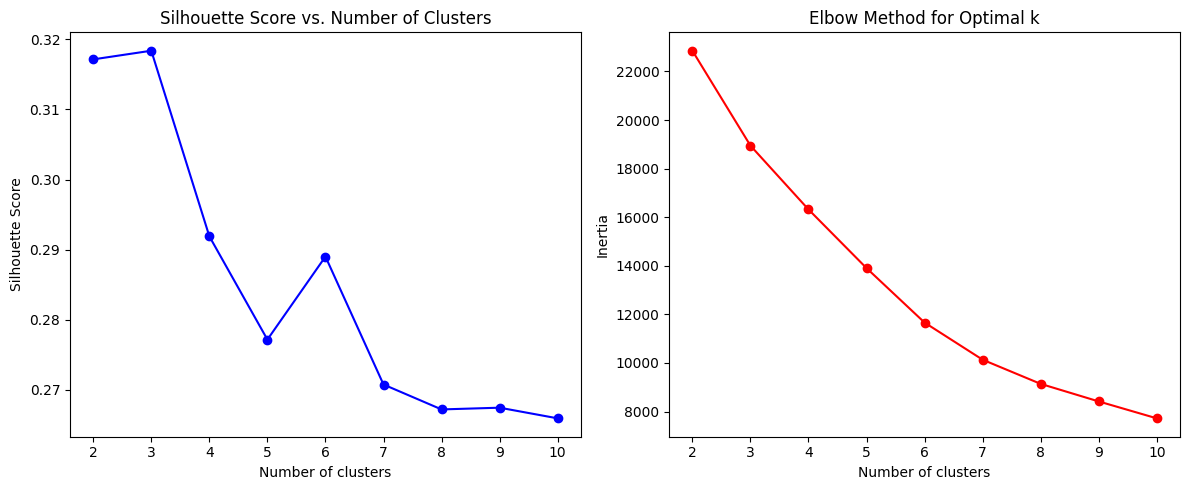

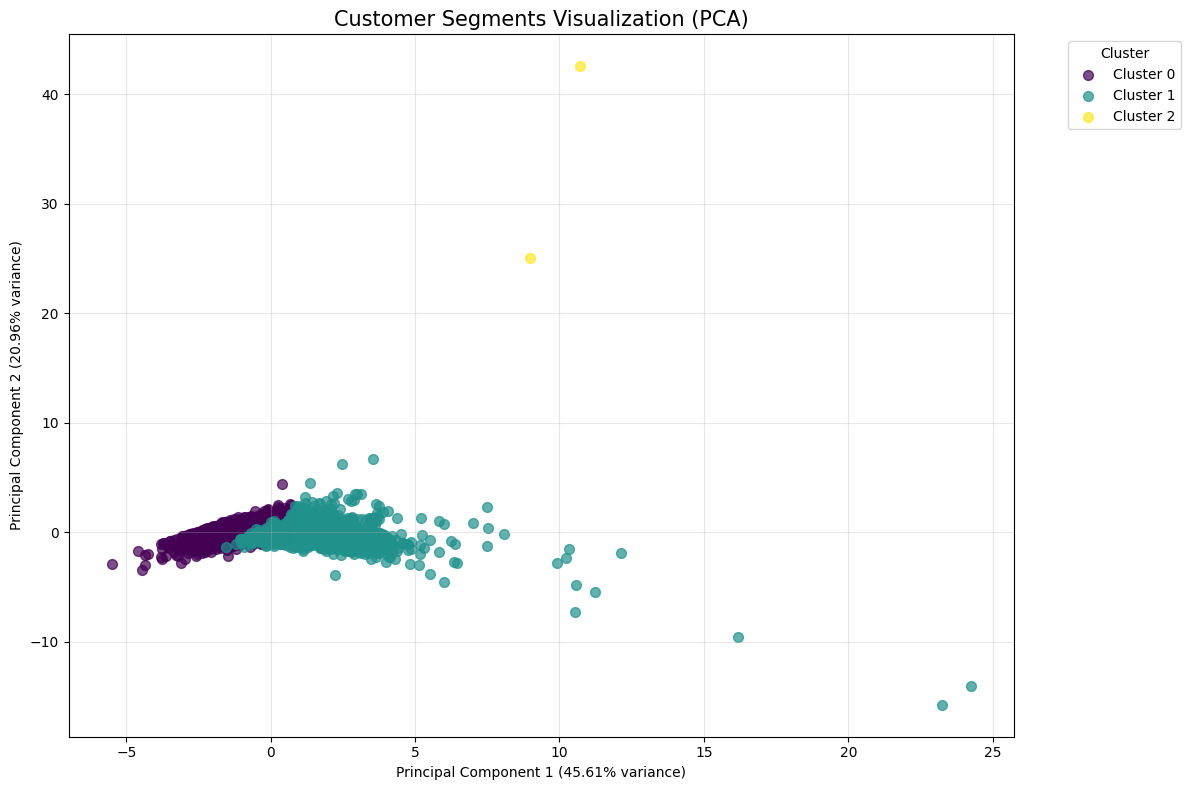

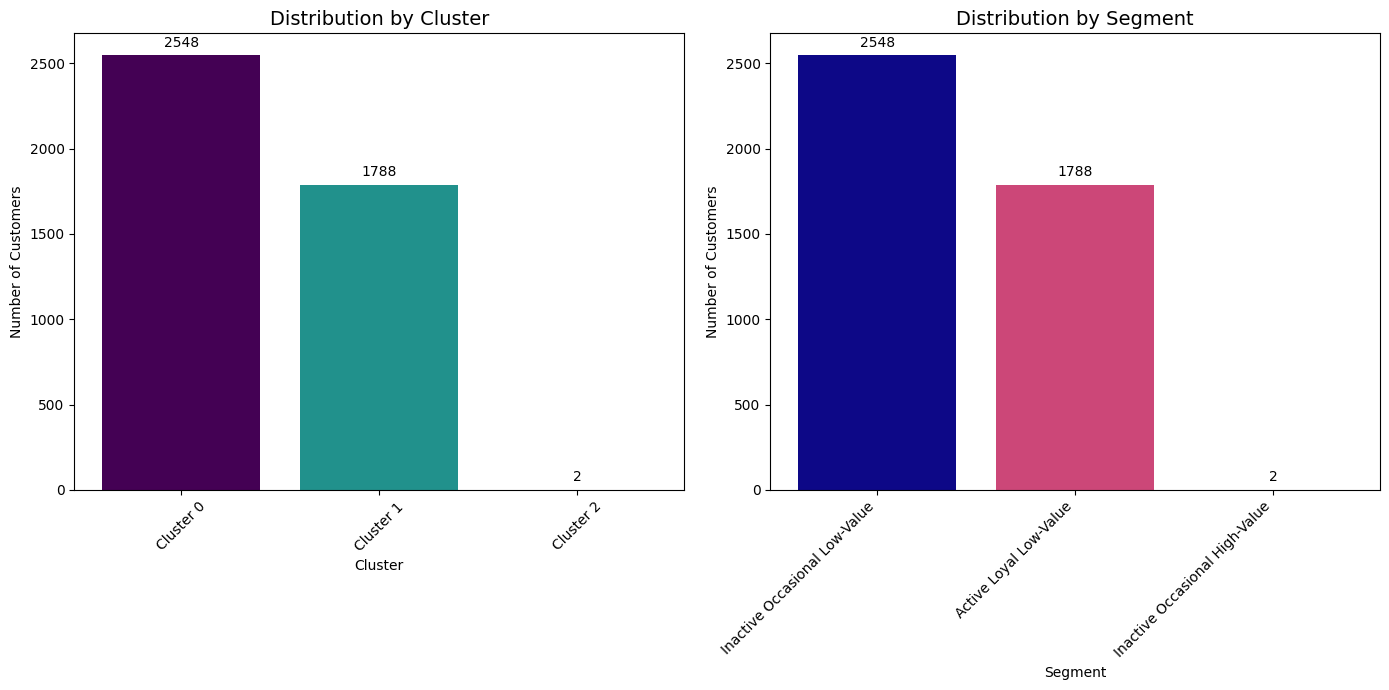

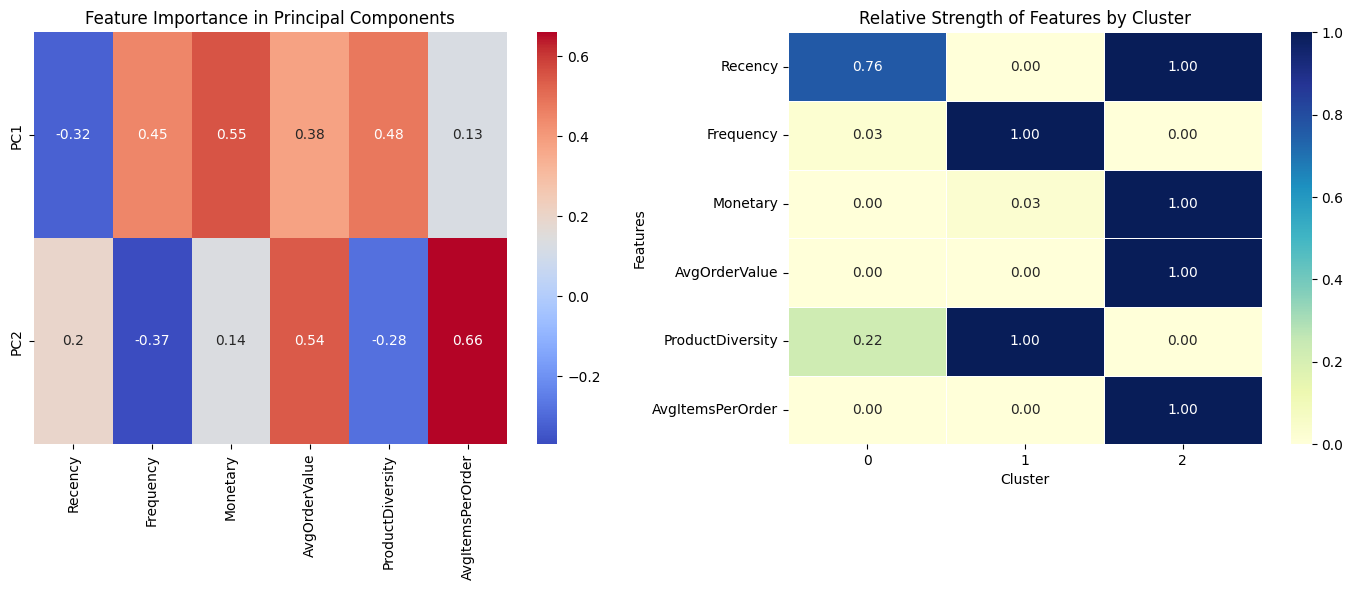

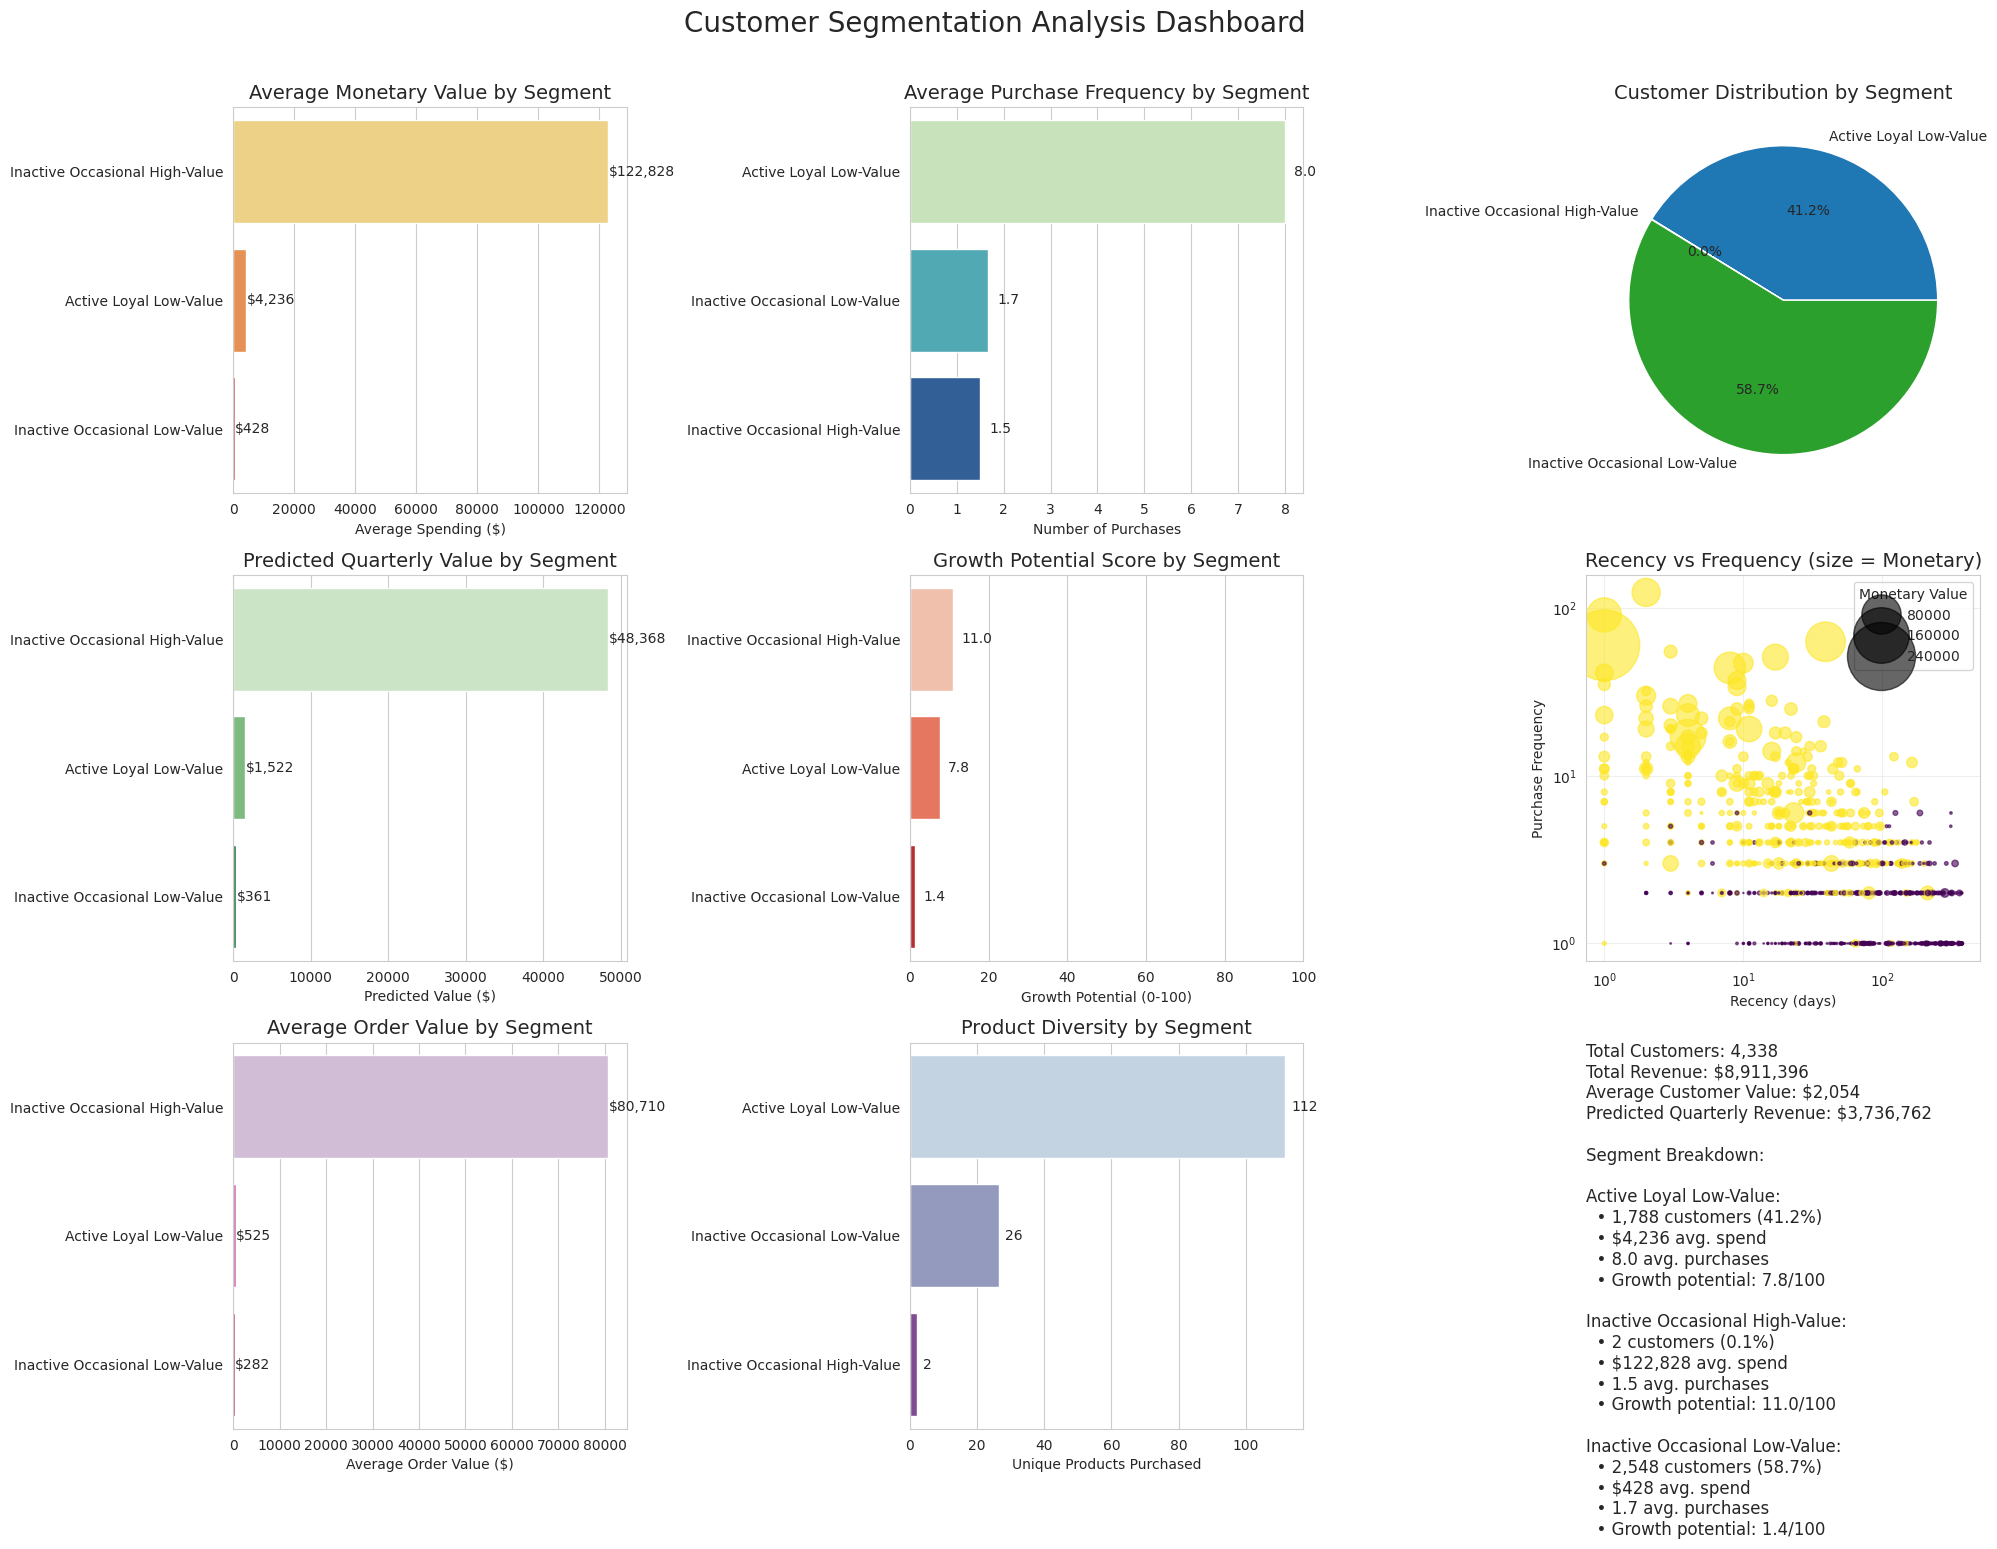

In [29]:
if __name__ == "__main__":
    # Run the enhanced analysis
    results = run_enhanced_analysis()

    # Display segment insights
    print("\nSegment Insights:")
    print(results['segment_insights'])

    print("\nResults saved to files:")
    print("- Full customer data with segments: customer_segments.csv")
    print("- Segment insights summary: segment_insights.csv")
    print("- Segment analysis and recommendations: segment_analysis.md")
    print("- PowerBI integration files: retail_analysis_*.csv")